## <font color='gray'>Отчет по домашнему заданию 2</font>
###  <font color='gray'>Выполнила:</font> Евсикова Дарья Алексеевна
### <font color='gray'>МОиАД, 1 курс</font>

________________________________

### Задача:

Минимизировать функцию потерь $F_{train} \underset{w}{\rightarrow} min$:

$$F_{train}(w) = - \frac{1}{N}\sum_{i=1}^{N}{y_i}\log{(\sigma_w(x_i))} + (1-y_i)\log{(1-\sigma_w(x_i))},$$
где $\sigma_w(x) = \dfrac{e^{w^{T}x}}{1 + e^{w^{T}x}}$

## Пункт 1

- Формулировка задачи в матричном виде: 

Найти вектор весов $w$ (вектор-столбец), при котором $F_{train}$ минимальна

$$F_{train}(w) = - \frac{1}{N}{Y^T}\log{(\sigma(X\cdot w))} + (1-Y)^T\log{(1-\sigma(X\cdot w))},$$


- Градиент в векторном виде:

$$\nabla F(w) = - \frac{1}{N}\big[ Y^T \cdot \log{\sigma\;(X\cdot w)} - (1 - Y)^T \cdot \log{(1-\sigma\;(X\cdot w))}\big]$$

- Гессиан в векторном виде:
$$\nabla^2 F(w) = \frac{1}{N}\big[ X^T \cdot \sigma(X\cdot w)(1-\sigma(X\cdot w))\cdot X \big]$$
$$$$


где $\sigma(X\cdot w)(1-\sigma(X\cdot w))$ диагональная матрица, в которой на диагонали расположены: $\sigma(w^Tx_i)\cdot(1-\sigma(w^Tx_i))$, остальные элементы - нули

Функция кросс-энтропии для логистической регрессии является выпуклой функцией. 
Согласно теореме о глобальной сходимости, все используемые в данной работе методы (GD, Newton, Hessian-Free Newton) будут сходиться к глобальному минимуму из любого начального приближения, но с различной скоростью. В методе Ньютона, например, скорость сходимости становится квадратичной в окрестности локального минимума, где метод, в теории, сходится за 1 итерацию. Если же начальная точка выбрана для метода Ньютона неудачно, то потребуется большее количество итераций. В том числе скорость сходимости будет зависеть и от численных результатов, т.к. работаем не в точной арифметике. Однако, теоретически, все методы должны сходиться из любой начальной точки.

<br>

## Пункт 2

Согласно полученным в пункте 1 формулам, были реализованы __оракулы__ нулевого, первого и второго порядка. Реализация расположена в файле `oracle.py`

Для реализованного класса `Oracle` были написаны тесты для проверки корректности вычисления производных.

In [1]:
import oracle
from test_oracle import test_grad, test_hessian

- __Тест для градиента__:

Проверка корректности вычисления градиента заключалась в сравнении с результатами, полученными при разностном дифференцировании:

$$\frac{\partial f}{\partial x_i}(x) \approx \frac{f(x+\epsilon e_i) - f(x-\epsilon e_i)}{2\epsilon}$$

где $e_i$ - вектор $(0,...,1,...,0)$, где на $i$ позиции стоит 1, а на остальных 0.


Аппроксимация градиента была реализована при $\epsilon=10^{-5}$. 
Сравнение численной аппроксимации с аналитическим значением функции `oracle.grad()` осуществлялось с помощью `np.allclose(grad_true, grad_test, rtol=eps)`

Для случайных 10 векторов, имеющих распределение $\sim \text{Unif}[-1,1]$, были подсчитаны градиенты численно и аналитически. Более подробные детали реализации в файле `test_oracle.py`

In [2]:
# инициализируем оракул на датасете a1a
my_oracle = oracle.make_oracle(data_path='data/a1a.txt')

# запустим функцию тестирования градиента
test_grad(my_oracle)

Results of calc gradient for 10 random datapoints via func np.allclose():


[True, True, True, True, True, True, True, True, True, True]

Таким образом, для 10 случайных векторов градиент функции, с помощью реализации из `Oracle`, посчитан верно при точности $\epsilon = 10^{-5}$

- __Тест для Гессиана__:

Для вычисления Гессиана с помощью разностного дифференцирования используем разложение в ряд Тейлора:

$$\nabla f(x+\epsilon p) = \nabla f(x) + \epsilon \nabla^2 f(x)p + O(\epsilon^2)$$

Отсюда можем выразить произведение Гессиана на вектор $p$ через:

$$\nabla^2 f(x)p \approx \frac{\nabla f(x+\epsilon p) - \nabla f(x - \epsilon p)}{2\epsilon}$$

Таким образом, используя в качестве векторов $p$ стандартный ортонормированный базис, получим аппроксимацию Гессиана.

Аппроксимация Гессиана также была получена для $\epsilon=10^{-5}$. 
Сравнение с функцией `oracle.hessian()` осуществлялось с помощью `np.allclose(hessian_true, hessian_test, rtol=eps)`

Для случайных 10 векторов, имеющих распределение $\sim \mathcal{N}[0,1]$, были подсчитаны Гессианы численно и аналитически. Результаты функции np.allclose для этих 10 векторов следующие:

In [3]:
test_hessian(my_oracle)

Results of calc Hessian for 10 random datapoints via func np.allclose():


[True, True, True, True, True, True, True, True, True, True]

Следовательно, как градиент, так и Гессиан, корректно вычисляются с помощью реализованного оракула.

Можем уверенно использовать их для решения искомой задачи оптимизации.

<br>

## Пункт 3

__Все дальнейшие реализации методов содержатся в файле `optimize.py`__

Методы реализованы в соответствующих классах:
`OptimizeGD`, `OptimizeNewton`, `OptimizeHFN`

Вызов функции `optimize` происходит как вызов метода `optimize(args)` для инстанса соответствующего класса

В полях класса хранится статистика работы метода, которые обновляются при каждом запуске `optimize`

### Метод градиентного спуска со стратегией выбора шага:
- методом золотого сечения
- методом брента
- с условиями Армихо
- с условиями Вульфа
- с определением константы Липшица (метод Нестерова)

Среди перечисленных методов самостоятельно были реализованы: метод золотого сечения, Армихо и метод Нестерова. Метод брента и Вульфа были взяты из библиотеки `scipy`

In [4]:
import oracle
import optimize as opt
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import log_loss
import numpy as np
from tabulate import tabulate
plt.style.use('ggplot')

In [5]:
my_oracle = oracle.make_oracle(data_path='data/a1a.txt')

Сразу же __определим бенчмарк__ для решаемой задачи, посчитав кросс-энтропию для логистической регрессии из `sklearn`

Будем использовать полученное значение в качестве $F(w_*)$ при анализе динамики $r_k$

In [6]:
X = my_oracle._X
y = my_oracle._y
lr = LogisticRegression(penalty='none', max_iter=1000).fit(X, np.ravel(y))
benchmark = log_loss(y, lr.predict_proba(X))
print('Optimal entropy:', benchmark)

Optimal entropy: 0.2978757199669842


<br>

Инициализируем функции для __построения графиков__:

In [7]:
def stats_for_plot(f, w, method='gd'):
    stats = dict()
    if method == 'gd':
        optimizer = opt.OptimizeGD()
        methods = ('golden', 'brent', 'armijo', 'wolfe', 'lipschitz')
        max_iter = 10000
    elif method == 'newton':
        optimizer = opt.OptimizeNewton()
        methods = ('golden', 'brent', 'armijo', 'wolfe')
        max_iter = 500
    elif method == 'hfn':
        optimizer = opt.OptimizeHFN()
        policies = ('constant', 'sqrtGradNorm', 'gradNorm')
        max_iter = 300
    else:
        raise ValueError('Incorrect method')
    
    if method == 'hfn':
        for policy in policies:
            d = dict()
            w_opt = optimizer.optimize(f, w, tol=1e-8, policy=policy, tol_eta=0.5, max_iter=max_iter)
            d['func'] = optimizer.func_values
            d['norm_sq'] = optimizer.grad_norm_k
            d['time'] = optimizer.time
            d['calls'] = optimizer.oracle_num_calls
            d['iter'] = optimizer.num_iter
            d['w_opt'] = w_opt
            stats[f'HFN: {policy}'] = d
    else:
        for ls in methods:
            d = dict()
            w_opt = optimizer.optimize(f, w, line_search_method=ls, tol=1e-8, max_iter=max_iter)
            d['func'] = optimizer.func_values
            d['norm_sq'] = optimizer.grad_norm_k
            d['time'] = optimizer.time
            d['calls'] = optimizer.oracle_num_calls
            d['iter'] = optimizer.num_iter
            d['w_opt'] = w_opt
            stats[ls] = d
    
    return stats

In [8]:
def plot_stats(stats, benchmark, plot_type='iter', title='plot'):
    
    '''
        Parameters
        ----------
        plot_type: iter, calls, time
    
    '''
    if plot_type == 'iter':
        x_label = 'Количество итераций'
    elif plot_type == 'calls':
        x_label = 'Количество вызовов оракула'
    elif plot_type == 'time':
        x_label = 'Время работы метода'
    
    
    fig, axs = plt.subplots(1,2, figsize=(14,4))
    
    for linesearch in stats.keys():
        iters = stats[linesearch][plot_type]
        rk1 = stats[linesearch]['norm_sq']
        norm_sq_0 = rk1[0]
        rk1 = np.log(rk1 / norm_sq_0)
        rk2 = stats[linesearch]['func']
        score = np.around(rk2[-1], 6)
        rk2 = np.log(np.absolute(rk2 - benchmark))         
        axs[0].plot(iters, rk1, label = f"{linesearch}: {score}", linewidth=3, linestyle='-')
        axs[1].plot(iters, rk2, label = linesearch, linewidth=3, linestyle='-')
    
    fig.suptitle(title, fontsize=15)

    axs[0].set(xlabel=x_label)
    axs[0].set(ylabel="log $||F(w_k)||^2$ / $||F(w_0)||^2$")
    axs[0].legend(facecolor='white', fontsize=12)

    axs[1].set(xlabel=x_label)
    axs[1].set(ylabel="log $|F(w_k) - F(w*)|$")
    axs[1].legend(facecolor='white', fontsize=12)
    
    plt.show()

<br>


Теперь построим __графики для анализа работы метода градиентного спуска__ с разными стратегиями `line search`:

In [9]:
# start point
w = np.zeros((my_oracle.num_features, 1))

In [10]:
# соберем всю статистику, необходимую для построения графиков = запустим GD для всех стратегий
stats_gd = stats_for_plot(my_oracle, w, method='gd')

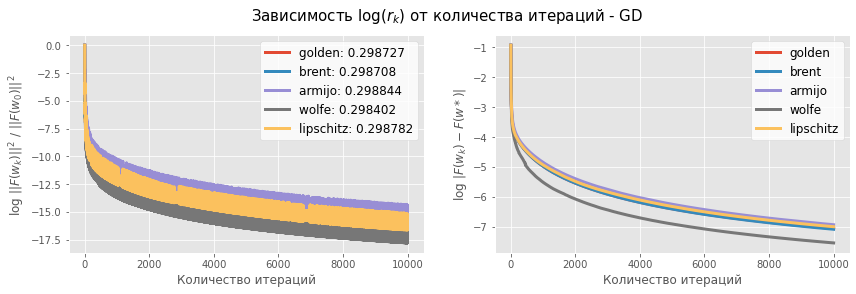

In [11]:
plot_stats(stats_gd, benchmark, plot_type='iter', title='Зависимость $\log{(r_k)}$ от количества итераций - GD')

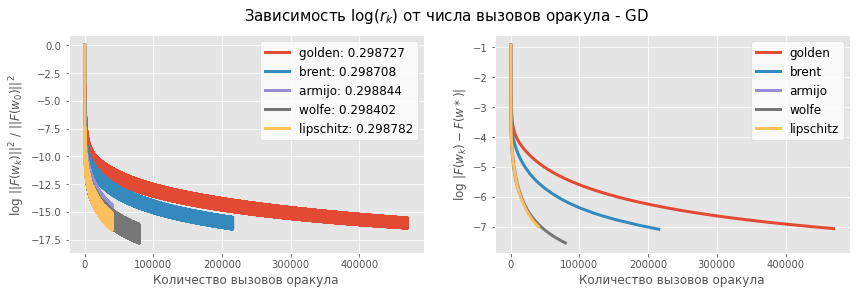

In [12]:
plot_stats(stats_gd, benchmark, plot_type='calls', title='Зависимость $\log{(r_k)}$ от числа вызовов оракула - GD')

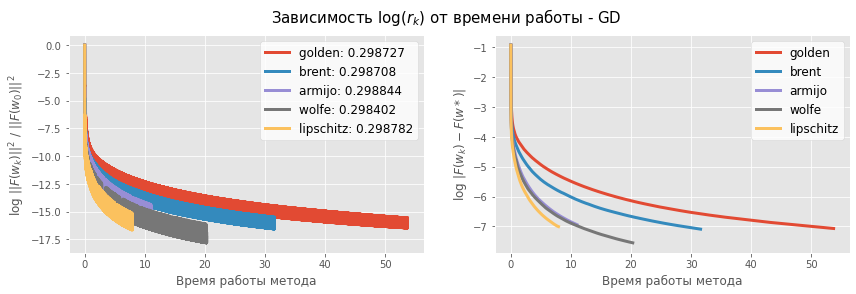

In [13]:
plot_stats(stats_gd, benchmark, plot_type='time', title='Зависимость $\log{(r_k)}$ от времени работы - GD')

__Выводы для метода градиентного спуска на датасете a1a:__
- Ни одна из стратегий выбора шага не позволила методу градиентного спуска сойтись до требуемой точности $10^{-8}$
- На всех графиках относительной точности видно, что шаги градиентного спуска идут зигзагом
- Оптимальнее всех по времени работы и по количеству вызовов оракула оказался __метод Нестерова__  
- Методы точной одномерной минимизации - __методы Брента и золотого сечения__ работают довольно долго, а также они потребовали наибольшее количество вызовов оракула
- В целом, по всем трем критериям, __предпочтительнее всех кажется метод Вульфа__ - он достигает лучшей точности; время его работы одно из самых наименьшиих; количество вызовов оракула - не такое критичное, как для точных методов

<br>

При этом, параметры в методах неточной оптимизации были подобраны следующим образом:

- Для `line search` с условиями __Армихо__

    Можем варьировать параметры: 

    $\eta$ - параметр, на который мы домножаем текущее альфа, если условие Армихо не выполнено

    $c$ - параметр из условия Армихо; согласно лекции, должен быть $\le 0.5$

In [18]:
def check_armijo_wolfe(ls_params, my_oracle, w, method='armijo'):
    check = opt.OptimizeGD()
    w_new = check.optimize(my_oracle, w, line_search_method=method, tol=1e-8, max_iter=10000, **ls_params)
    return check

def print_res(params, my_oracle, w, method='armijo'):
    res = []
    for par in params:
        test = check_armijo_wolfe(par, my_oracle, w, method)
        res += [[*par.values(), 
               test.func_values[-1], 
               np.absolute(test.func_values[-1] - benchmark), 
               test.time[-1],
               test.num_iter[-1]]]
    columns = [*par.keys(), 'entropy', 'abs error', 'time', 'num_iter']
    print(tabulate(res, headers=columns))

In [19]:
params = [{'eta': 0.5, 'c': 0.01}, 
          {'eta': 0.5, 'c': 0.2},
          {'eta': 0.5, 'c': 0.5},
          {'eta': 0.2, 'c': 0.01},
          {'eta': 0.01, 'c': 0.01},
          {'eta': 0.3, 'c': 0.2}]

print_res(params, my_oracle, w, method='armijo')

  eta     c    entropy    abs error     time    num_iter
-----  ----  ---------  -----------  -------  ----------
 0.5   0.01   0.298844  0.000968219  11.7216       10000
 0.5   0.2    0.298843  0.00096764   11.2698       10000
 0.5   0.5    0.298782  0.000906308  10.9084       10000
 0.2   0.01   0.298704  0.000828065  11.3639       10000
 0.01  0.01   0.298504  0.000628206  11.26         10000
 0.3   0.2    0.298806  0.000929807  11.5478       10000


__Следовательно__, для параметров $\eta$ и $c$ в интервалах $\eta \in (0, 0.5]$ и $c \in (0, 0.5]$ результаты по итоговой метрике __различаются по абсолютной ошибке, начиная с 4 знака__. Поскольку метод с использованием условий Армихо - метод неточной оптимизации, то четкий подбор данных параметров приведет к микрооптимизациям метрики на конкретном датасете (т.е. $\sim$ 'переобучению' под датасет). Поэтому в качестве параметров были выбраны `eta=0.5, c=0.0001`

<br>

- Для `line search` с условиями __Вульфа__

    Можем варьировать параметры: 

    $c_1$ - параметр для условия Армихо

    $c_2$ - параметр для второго условия Вульфа
    
    $amax$ - максимальная длина шага

In [20]:
params = [{'c1': 1e-4, 'c2': 0.6, 'amax': 10},
          {'c1': 1e-4, 'c2': 0.3, 'amax': 20},
          {'c1': 1e-2, 'c2': 0.9, 'amax': 5},
          {'c1': 1e-2, 'c2': 0.6, 'amax': None},
          {'c1': 0.3, 'c2': 0.3, 'amax': None},
          {'c1': 0.3, 'c2': 0.9, 'amax': None}]

print_res(params, my_oracle, w, method='wolfe')

C:\python\lib\site-packages\scipy\optimize\linesearch.py:437: LineSearchWarning: The line search algorithm could not find a solution less than or equal to amax: 10
  warn(msg, LineSearchWarning)
C:\python\lib\site-packages\scipy\optimize\linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\python\lib\site-packages\scipy\optimize\linesearch.py:437: LineSearchWarning: The line search algorithm could not find a solution less than or equal to amax: 20
  warn(msg, LineSearchWarning)
C:\python\lib\site-packages\scipy\optimize\linesearch.py:437: LineSearchWarning: The line search algorithm could not find a solution less than or equal to amax: 5
  warn(msg, LineSearchWarning)


    c1    c2    amax    entropy    abs error     time    num_iter
------  ----  ------  ---------  -----------  -------  ----------
0.0001   0.6      10   0.300533  0.00265718   37.3775       10000
0.0001   0.3      20   0.300529  0.00265303   41.5364       10000
0.01     0.9       5   0.300529  0.00265349   33.2275       10000
0.01     0.6           0.298545  0.000669027  20.2564       10000
0.3      0.3           0.29884   0.000964681  21.1269       10000
0.3      0.9           0.298401  0.000525098  19.8194       10000


__Таким образом__, для условий Вульфа лучше __не ограничивать максимальную длину шага__. Это приводит к замедлению времени работы в 2 раза, а также к увеличению ошибки. В данном случае метод даже вернул соответствующие ворнинги о проблемах со сходимостью

Параметры $c_1$ и $c_2$ при `amax=None` __неособенно влияют на общую производительность/точность работы алгоритма__. Ошибка различается на 4 знаке, что некритично для метода неточной оптимизации. Таким образом, лучше оставить данные параметры с дефолтными значениями: `c1=1e-4, c2=0.9`

<br>

## Пункт 4

### Метод Ньютона со стратегией выбора шага:
- методом золотого сечения
- методом брента
- с условиями Армихо
- с условиями Вульфа

В качестве коррекции Гессиана использовалась коррекция с помощью положительной "добавки": $H= H + \tau I$,

где $\tau$ подбиралась адаптивно со стартового значения `tau = 1e-4`

In [14]:
w = np.zeros((my_oracle.num_features, 1))

In [15]:
stats_newton = stats_for_plot(my_oracle, w, method='newton')

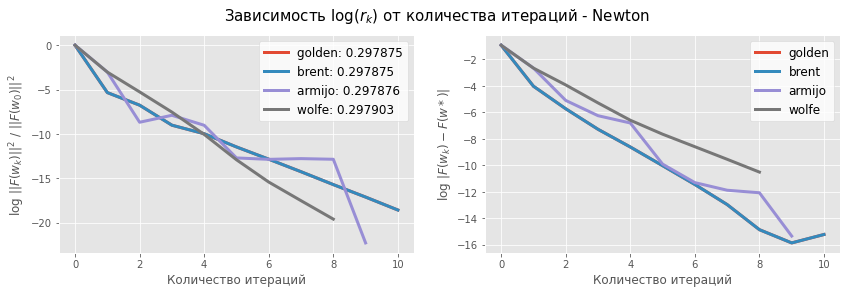

In [16]:
plot_stats(stats_newton, benchmark, plot_type='iter', title='Зависимость $\log{(r_k)}$ от количества итераций - Newton')

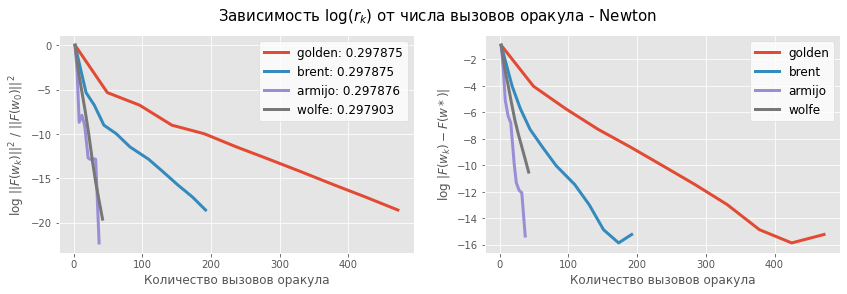

In [17]:
plot_stats(stats_newton, benchmark, plot_type='calls', title='Зависимость $\log{(r_k)}$ от числа вызовов оракула - Newton')

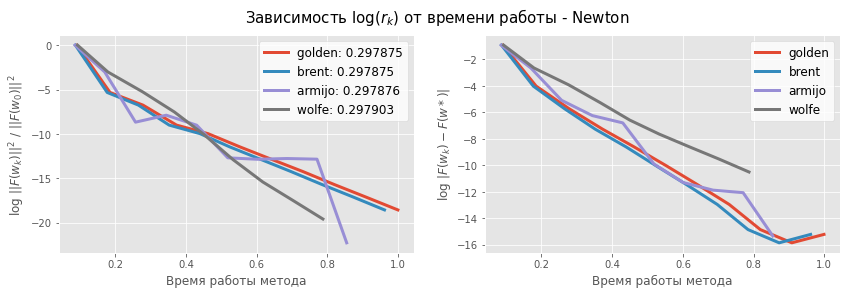

In [18]:
plot_stats(stats_newton, benchmark, plot_type='time', title='Зависимость $\log{(r_k)}$ от времени работы - Newton')

__Выводы для метода Ньютона на датасете a1a:__
- Все методы поиска по прямой сошлись до $10^{-8}$ менее, чем за 3 секунды, что в десятки раз быстрее, чем для градиентного спуска
- Методы точной одномерной оптимизации - __Брент и метод золотого сечения__ - на первых графиках "наложились" друг на друга - т.е. они достигают одинаковой точности на k-ой итерации метода Ньютона
- Методы точной одномерной минимизации - оказались ожидаемо точнее остальных, но более "дорогими" с точки зрения обращения к оракулу
- В относительной точности, __предпочтительнее всех кажется метод Вульфа__. Данный метод, а также __метод Армихо__ - примерно сопоставимы по результатам, но Вульф более стабильно сходится, по сравнению с Армихо. Более того, в Вульфе был использован следующий прием: если Вульфу не удалось сойтись и был возвращен `None`, то ищем шаг по Армихо. Т.е. метод Вульфа в целом более предпочтителен. Он проверяет более сильные условия, чем условия Армихо. Но если он не сходится, то шаг подменяется шагом Армихо.
<br>

## Пункт 5

### Hessian-Free Newton

В данном методе мы можем варьировать точность для решения задачи поиска направления методом сопряженных градиентов.

Для этого в методе используется параметр `policy`, который может принимать 3 значения:
- `policy=constant` - $\eta_k = c$ - приведет к линейной сходимости метода
- `policy=gradNorm` - $\eta_k = \min{(0.5, {||\nabla f_k||})}$ - соответствует квадратичной сходимости
- `policy=sqrtGradNorm` - $\eta_k = \min{(0.5, \sqrt{||\nabla f_k||})}$ - соответствует суперлинейной сходимости

Рассмотрим характеристики работы метода в зависимости от конкретной стратегии:

In [19]:
# start point
w = np.zeros((my_oracle.num_features, 1))

In [20]:
stats_hfn = stats_for_plot(my_oracle, w, method='hfn')

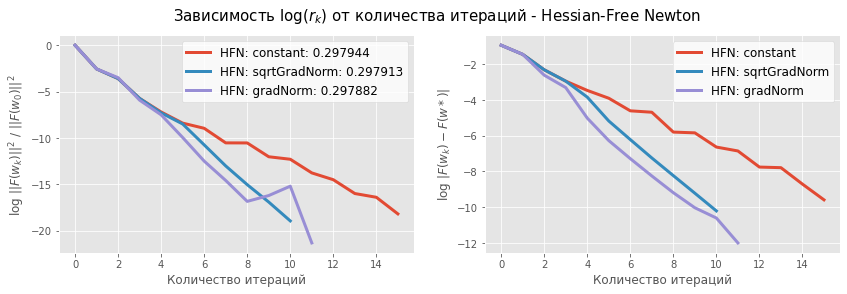

In [21]:
plot_stats(stats_hfn, benchmark, plot_type='iter', 
           title='Зависимость $\log{(r_k)}$ от количества итераций - Hessian-Free Newton')

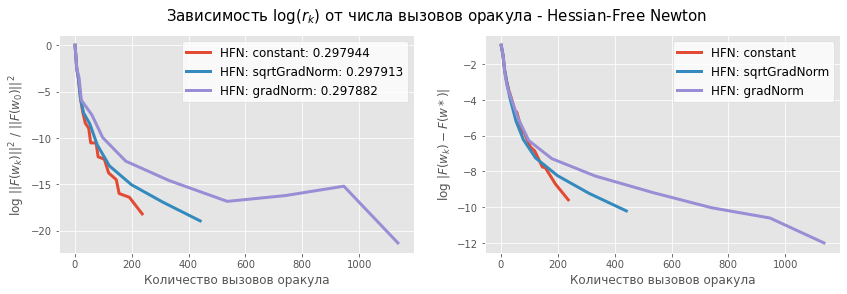

In [22]:
plot_stats(stats_hfn, benchmark, plot_type='calls', 
           title='Зависимость $\log{(r_k)}$ от числа вызовов оракула - Hessian-Free Newton')

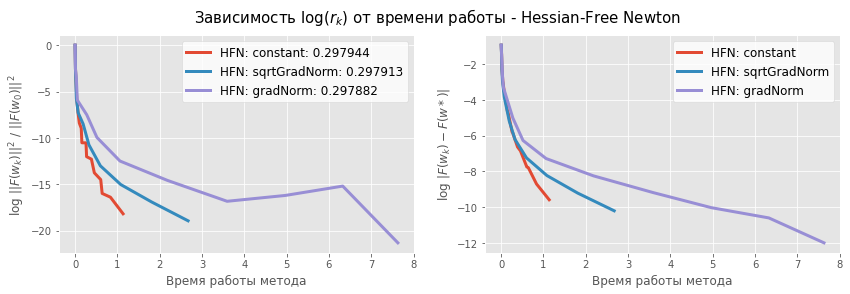

In [23]:
plot_stats(stats_hfn, benchmark, plot_type='time', 
           title='Зависимость $\log{(r_k)}$ от времени работы - Hessian-Free Newton')

__Выводы для метода Hessian-Free Newton на датасете a1a:__

- Стратегия выбора точности для задачи сопряженных градиентов влияет на достигаемую точность для минимизируемой функции и на скорость, с которой это происходит

- Графики выше соответствуют начальным утверждениям: метод со стратегией `policy = gradNorm` сходится к лучшему значению функции за одинаковое количество итераций по сравнению с остальными стратегиями

- В целом, данные стратегии неособенно различимы по времени и количеству итераций. А константная стратегия очевидно лучше остальных по количеству обращений к оракулу. 

- Выбор того, какую из стратегий использовать, зависит от желаемых результатов. Если необходимо достигнуть лучшей точности - то лучше себя поведет `policy = gradNorm`. Если необходимо минимизировать количество обращений к оракулу и время выполнения - лучше использовать `policy = constant`. Оставшаяся стратегия `policy = sqrtGradNorm` будет компромисным вариантом, поэтому именно это значение установлено в качестве дефолтного.

- Поскольку метод HFN необходим для оптимизации метода Ньютона в плане используемой памяти, то этот метод, в целом, более предпочтителен. Но если требуется более точный метод, то тогда Ньютон с точным вычислением Гессиана ожидаемо даст лучшую точность

<br>

## Сравнение методов

In [24]:
stats_best = dict()
stats_best['GD - Wolfe'] = stats_gd['wolfe']
stats_best['Newton_Armijo'] = stats_newton['armijo']
stats_best.update(stats_hfn)

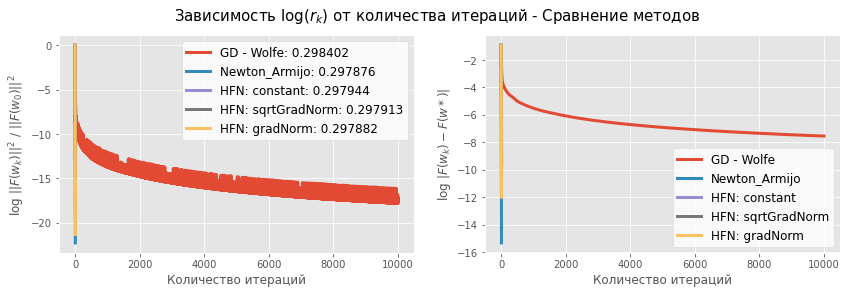

In [25]:
plot_stats(stats_best, benchmark, plot_type='iter', 
           title='Зависимость $\log{(r_k)}$ от количества итераций - Сравнение методов')

#### Очевидно, что метод градиентного спуска проигрывает всем методом, как по точности, так и по скорости сходимости

Посмотрим на те же графики без него

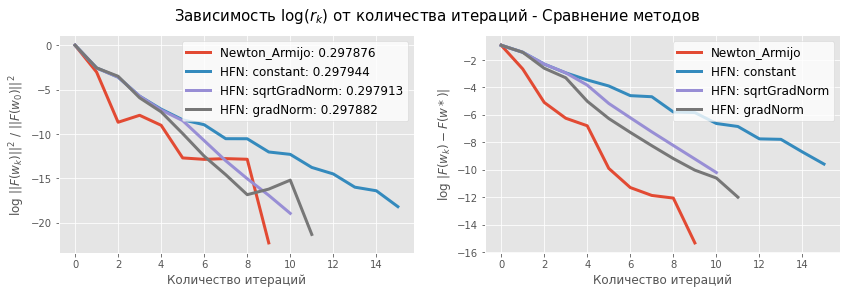

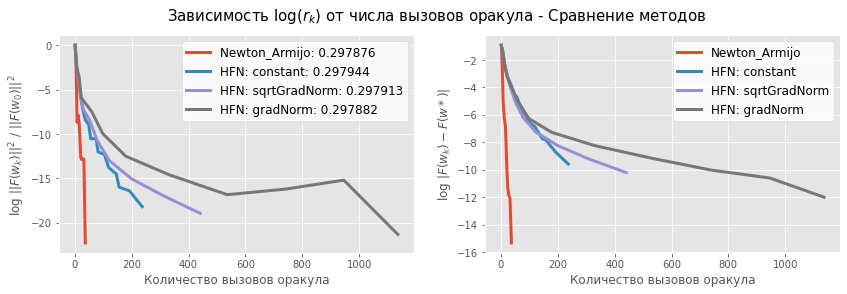

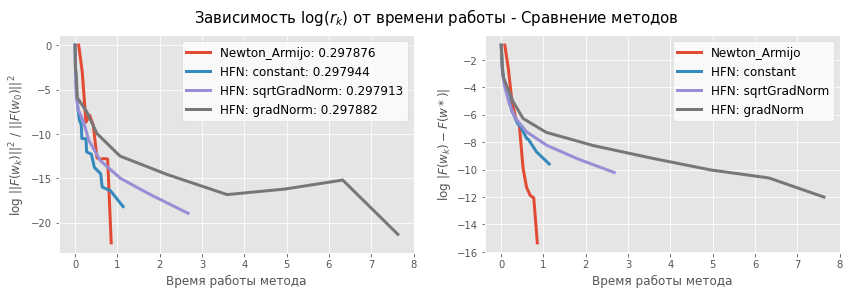

In [26]:
stats_best = dict()
stats_best['Newton_Armijo'] = stats_newton['armijo']
stats_best.update(stats_hfn)
plot_stats(stats_best, benchmark, plot_type='iter', 
           title='Зависимость $\log{(r_k)}$ от количества итераций - Сравнение методов')
plot_stats(stats_best, benchmark, plot_type='calls', 
           title='Зависимость $\log{(r_k)}$ от числа вызовов оракула - Сравнение методов')
plot_stats(stats_best, benchmark, plot_type='time', 
           title='Зависимость $\log{(r_k)}$ от времени работы - Сравнение методов')

__Выводы__:
- Лучшим по всем характеристикам стал метод Ньютона с поиском альфа при помощи Армихо
- Но данный метод требует достаточно больших затрат памяти из-за хранения Гессиана, поэтому HFN может быть предпочтительнее в этом плане 

<br>

## Дополнительно:


###  Тестирование на датасете breast-cancer

In [27]:
my_oracle = oracle.make_oracle(data_path='data/breast-cancer_scale.txt')

In [28]:
X = my_oracle._X
y = my_oracle._y
lr = LogisticRegression(penalty='none', max_iter=1000).fit(X, np.ravel(y))
benchmark1 = log_loss(y, lr.predict_proba(X))
print('Optimal entropy:', benchmark1)

Optimal entropy: 0.07531873603480535


In [29]:
# start point
w = np.zeros((my_oracle.num_features, 1))

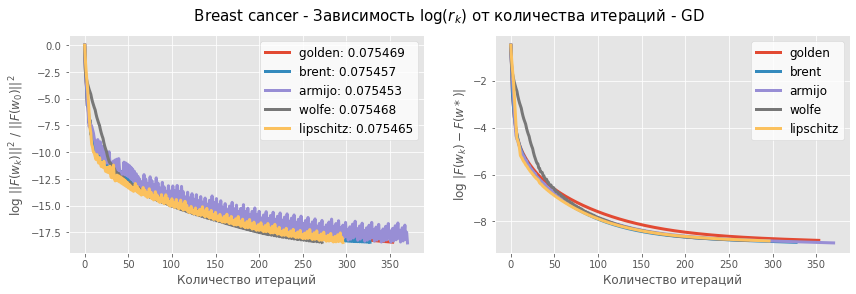

In [30]:
# соберем всю статистику, необходимую для построения графиков 
stats_gd_bc = stats_for_plot(my_oracle, w, method='gd')

plot_stats(stats_gd_bc, benchmark1, plot_type='iter', 
           title=' Breast cancer - Зависимость $\log{(r_k)}$ от количества итераций - GD')

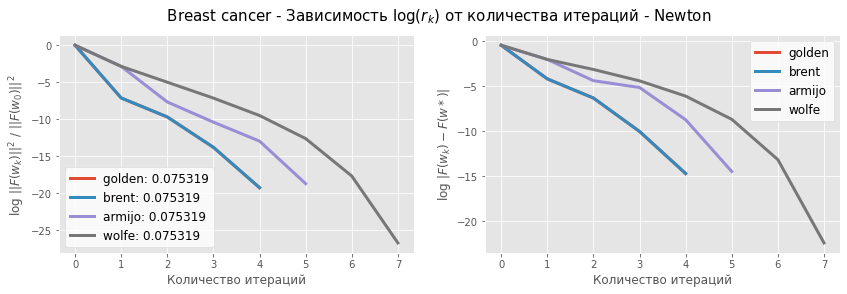

In [31]:
# соберем всю статистику, необходимую для построения графиков 
stats_newton_bc = stats_for_plot(my_oracle, w, method='newton')

plot_stats(stats_newton_bc, benchmark1, plot_type='iter', 
           title=' Breast cancer - Зависимость $\log{(r_k)}$ от количества итераций - Newton')

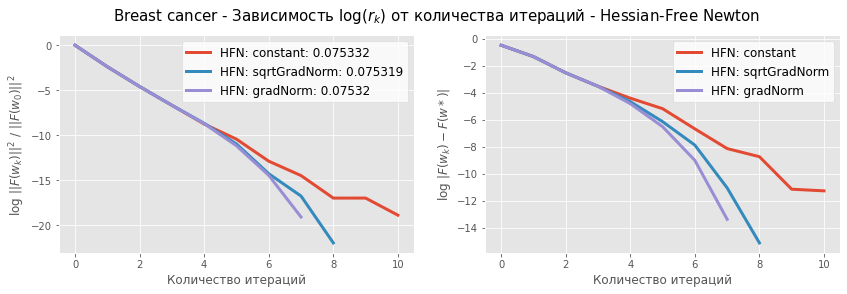

In [32]:
# соберем всю статистику, необходимую для построения графиков 
stats_hfn_bc = stats_for_plot(my_oracle, w, method='hfn')

plot_stats(stats_hfn_bc, benchmark1, plot_type='iter', 
           title='Breast cancer - Зависимость $\log{(r_k)}$ от количества итераций - Hessian-Free Newton')

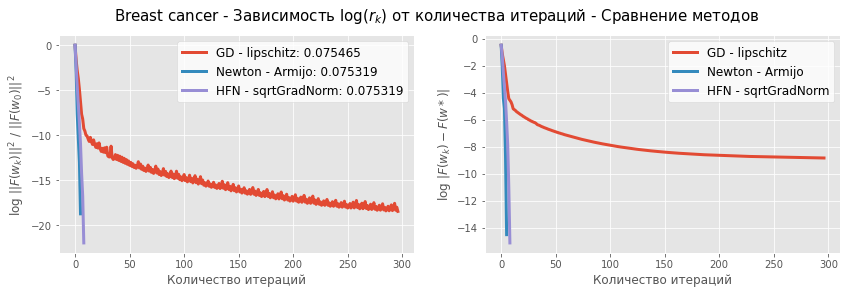

In [33]:
stats_best_bc = dict()
stats_best_bc['GD - lipschitz'] = stats_gd_bc['lipschitz']
stats_best_bc['Newton - Armijo'] = stats_newton_bc['armijo']
stats_best_bc['HFN - sqrtGradNorm'] = stats_hfn_bc['HFN: sqrtGradNorm']
plot_stats(stats_best_bc, benchmark1, plot_type='iter', 
           title='Breast cancer - Зависимость $\log{(r_k)}$ от количества итераций - Сравнение методов')

__Вывод__:
- Результаты примерно аналогичны предыдущему датасету - градиентный спуск проигрывает всем методам
- Метод Ньютона и HFN - примерно идентичны, поэтому HFN предпочтительнее


###  Тестирование на сгенерированных данных

In [34]:
# a1 * x1 + a2 * x2 + b = y

a1, a2, beta = np.random.uniform(-1, 1), np.random.uniform(-1, 1), np.random.uniform(-1, 1)
X = np.random.normal(loc=0, scale=1, size=(1000, 2))
X = np.hstack((X, np.ones((X.shape[0], 1))))
y = np.where(a1 * X[:, 0] + a2 * X[:, 1] + beta >= 0, 1, 0).reshape(-1, 1)
my_oracle = oracle.Oracle(X, y)

In [35]:
lr = LogisticRegression(penalty='none', max_iter=1000).fit(X, np.ravel(y))
benchmark2 = log_loss(y, lr.predict_proba(X))
print('Optimal entropy:', benchmark2)

Optimal entropy: 2.1168083940752936e-07


In [36]:
# start point
w = np.zeros((my_oracle.num_features, 1))

C:\python\lib\site-packages\scipy\optimize\linesearch.py:477: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\python\lib\site-packages\scipy\optimize\linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)


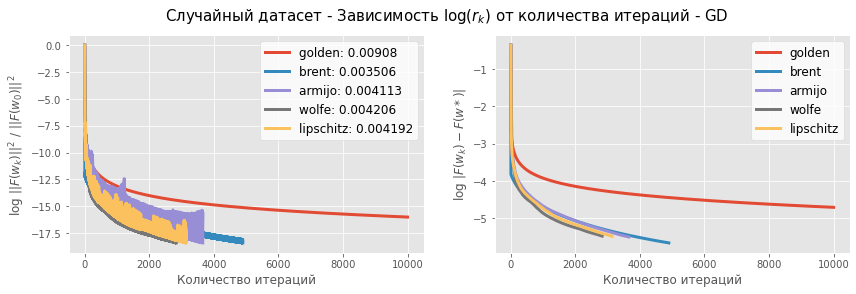

In [37]:
# соберем всю статистику, необходимую для построения графиков 
stats_gd_rand = stats_for_plot(my_oracle, w, method='gd')

plot_stats(stats_gd_rand, benchmark2, plot_type='iter', 
           title='Случайный датасет - Зависимость $\log{(r_k)}$ от количества итераций - GD')

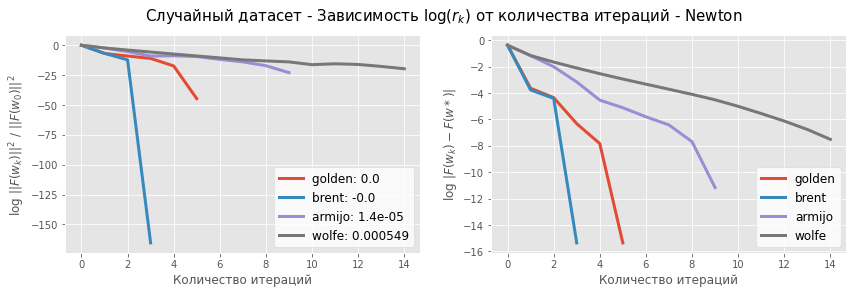

In [38]:
# соберем всю статистику, необходимую для построения графиков 
stats_newton_rand = stats_for_plot(my_oracle, w, method='newton')

plot_stats(stats_newton_rand, benchmark2, plot_type='iter', 
           title='Случайный датасет - Зависимость $\log{(r_k)}$ от количества итераций - Newton')

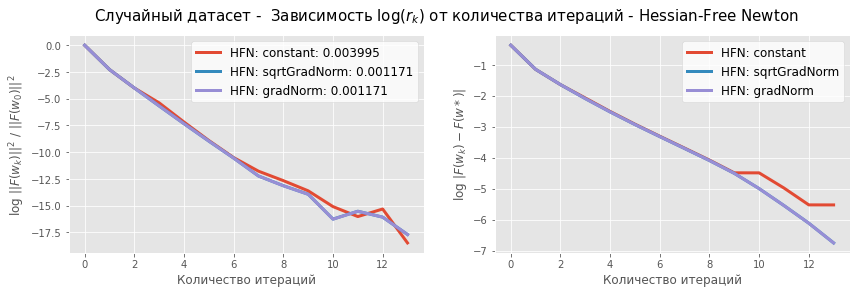

In [39]:
# соберем всю статистику, необходимую для построения графиков 
stats_hfn_rand = stats_for_plot(my_oracle, w, method='hfn')

plot_stats(stats_hfn_rand, benchmark2, plot_type='iter', 
           title='Случайный датасет -  Зависимость $\log{(r_k)}$ от количества итераций - Hessian-Free Newton')

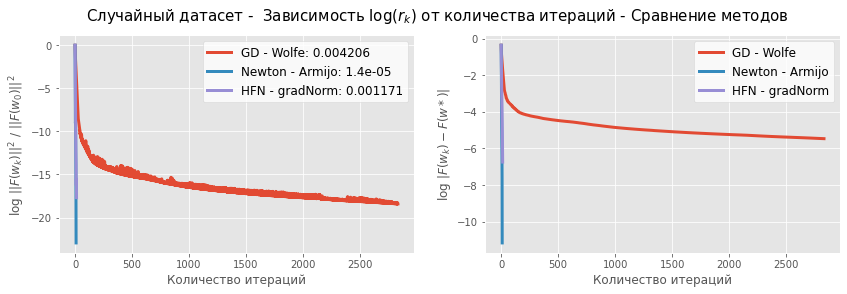

In [40]:
stats_best_rand = dict()
stats_best_rand['GD - Wolfe'] = stats_gd_rand['wolfe']
stats_best_rand['Newton - Armijo'] = stats_newton_rand['armijo']
stats_best_rand['HFN - gradNorm'] = stats_hfn_rand['HFN: gradNorm']
plot_stats(stats_best_rand, benchmark2, plot_type='iter', 
           title='Случайный датасет -  Зависимость $\log{(r_k)}$ от количества итераций - Сравнение методов')

________________________

### Общие выводы о работе методов:

- На практике методы показали не совсем однозначные результаты по сравнению с теорией
- __Метод градиентного спуска__ однозначно является самым медленным и недостаточно точным
- __Метод Ньютона__ довольно быстро сходится к нужной точности. Но бывают проблемы с начальным приближением - если в качестве $w_0$ выбрана точка, близкая к нулю, - метод гарантированно сойдется за разумное число итераций. Но если норма вектора направления оказалась слишком большой, то метод может "улететь" на бесконечность или застрять на плато из-за положительной полуопределенности гессиана. Поэтому для решения этой проблемы был использован `gradient clipping`. Это помогло решить проблему на начальных весах меньше $\sim 5$, но для больших начальных весов проблема не решилась
- __Метод Hessian Free Newton__ ожидаемо ведет себя похожим образом на метод Ньютона, но имеет главное преимущество - оптимизация используемой памяти

- В целом, подобных проблем со сходимостью отдельных методов можно было бы избежать, добавив в функцию потерь регуляризацию. Тогда любое начальное приближение, скорее всего, давало бы ожидаемый в теории результат